In [1]:
import pickle as pkl
import gzip
# joblib is used to load the model outputs
import joblib
import polyscope as ps
import polyscope.imgui as psim
from matplotlib import pyplot as plt
import os, sys
import numpy as np
import cv2
import time
from scipy.interpolate import interp1d
from scipy.spatial.transform import Slerp
from scipy.spatial.transform import Rotation as R

sys.path.insert(0, os.path.abspath("/scratch/ondemand27/evanpan/motion_instruction/smpl"))
sys.path.insert(0, os.path.abspath("/Users/evanpan/Documents/GitHub/Motion_instruction/smpl"))
from smpl.smpl_np import SMPLModel
from smpl.constants import *
from smpl.skeleton import *
# from smpl.smpl_webuser.serialization import load_model
# from phalp.utils import smpl_utils

In [2]:
# %matplotlib widget
%matplotlib inline
%load_ext autoreload
%autoreload 1

%aimport smpl.smpl_np

## Utility functions

In [18]:
def load_motion_data(motionData_path, main_guy):
    # load motion data
    motiondata = joblib.load(open(motionData_path, "rb"))
    frames = sorted(list(motiondata.keys()))
    per_frame_smpl_data = {"time":[], "beta":[], "pose":[], "position":[]}
    for i in range(0, len(frames)):
        frame_i = motiondata[frames[i]]
        # print(frame_i.keys())
        pose_i = frame_i["pose"] # this stores a list of poses for characters in the 
        center_i = frame_i["center"]
        scale_i = frame_i["scale"]
        smpl_i = frame_i["smpl"]
        ids_i = frame_i['tid']
        threeD_joints_i = frame_i['3d_joints']
        # only care about the guy of interest
        # print(ids_i)
        if main_guy not in ids_i:
            continue
        pose_i_main = pose_i[ids_i.index(main_guy)]
        threeD_joints_i_main = threeD_joints_i[ids_i.index(main_guy)] # shape is (43, 3)
        smpl_i_main = smpl_i[ids_i.index(main_guy)] # dictionary with keys ['global_orient', 'body_pose', 'betas']
        # get the smpl parameters
        global_orient = smpl_i_main["global_orient"] # defined root orentation (rotation matrix )
        body_pose = smpl_i_main["body_pose"] # defines the rotation matrix of the 23 joints (generated using Rodrigues formula)
        beta = smpl_i_main["betas"] # shape is (10,)
        # convert rotation matrices in body pose to axis-angle representation
        body_pose_aa = np.zeros((body_pose.shape[0], 3))
        for jj in range(body_pose.shape[0]):
            body_pose_aa[jj] = cv2.Rodrigues(body_pose[jj])[0].squeeze()
        # rotate global_orient by 180 degrees by x axis
        # global_orient[0] = cv2.Rodrigues(np.array([np.pi, 0, 0]))[0].squeeze() @ global_orient[0]
        global_orient_aa = np.array([cv2.Rodrigues(global_orient[0])[0].squeeze()])
        # check for discontinuities in the global orientation
        if global_orient_aa[0, 0] < 0:
            global_orient_aa *= -1
                    
        #             global_orient_aa[0][jj] *= -1
        # global_orient_aa[np.where(global_orient_aa > np.pi)] -= 2*np.pi
        # global_orient_aa[np.where(global_orient_aa < -np.pi)] += 2*np.pi
        body_pose_aa = np.concatenate([global_orient_aa, body_pose_aa], axis=0)
        # load data related to smpl model
        per_frame_smpl_data["time"].append(frame_i["time"])
        per_frame_smpl_data["beta"].append(beta)
        per_frame_smpl_data["pose"].append(body_pose_aa)
        per_frame_smpl_data["position"].append(np.zeros([3, ]))
    per_frame_smpl_data["beta"] = np.array(per_frame_smpl_data["beta"])
    per_frame_smpl_data["pose"] = np.array(per_frame_smpl_data["pose"])
    per_frame_smpl_data["position"] = np.array(per_frame_smpl_data["position"])
    per_frame_smpl_data["time"] = np.array(per_frame_smpl_data["time"])

    per_frame_smpl_data["pose_interp"] = interp1d(per_frame_smpl_data["time"], per_frame_smpl_data["pose"], axis=0, fill_value="extrapolate", bounds_error=False, kind="linear")
    
    per_frame_smpl_data["beta_interp"] = interp1d(per_frame_smpl_data["time"], per_frame_smpl_data["beta"], axis=0, fill_value="extrapolate", bounds_error=False)
    per_frame_smpl_data["position_interp"] = interp1d(per_frame_smpl_data["time"], per_frame_smpl_data["position"], axis=0, fill_value="extrapolate", bounds_error=False)
    return per_frame_smpl_data
    # print(per_frame_smpl_data["beta"].shape, per_frame_smpl_data["pose"].shape, per_frame_smpl_data["position"].shape)
class SlerpInterpolationMultiObject:
    def __init__(self, timestamps, rotation_vectors):
        """
        Initialize with timestamps and rotation vectors.   
        :param timestamps: Array of shape [T], where T is the number of timestamps.
        :param rotation_vectors: Array of shape [T, N, 3], where N is the number of objects,
                                 and each rotation vector is 3D.
        """
        self.timestamps = np.array(timestamps)
        self.rotations = []
        self.rotations_interps = []
        for i in range(0, rotation_vectors.shape[1]):
            self.rotations.append(R.from_rotvec(rotation_vectors[:, i]))
        for i in range(0, len(self.rotations)):
            self.rotations_interps.append(Slerp(self.timestamps, self.rotations[i]))
        self.num_objects = rotation_vectors.shape[1]
    def __call__(self, target_time):
        """
        Interpolate rotation vectors for each object at specified target times.
        
        :param target_times: Array of target times for interpolation.
        :return: Interpolated rotation vectors of shape [len(target_times), N, 3].
        """ 
        # target_times = np.atleast_1d(target_times)
        interpolated_rotations = []
        for i in range(0, len(self.rotations_interps)):
            interpolated_rotations.append(self.rotations_interps[i](target_time).as_rotvec())
        return np.array(interpolated_rotations)
def load_motion_data_slerp(motionData_path, main_guy):
    # load motion data
    motiondata = joblib.load(open(motionData_path, "rb"))
    frames = sorted(list(motiondata.keys()))
    per_frame_smpl_data = {"time":[], "beta":[], "pose":[], "position":[], "camera":[], "3Djoint_position":[]}
    for i in range(0, len(frames)):
        frame_i = motiondata[frames[i]]
        pose_i = frame_i["pose"] # this stores a list of poses for characters in the 
        center_i = frame_i["center"]
        scale_i = frame_i["scale"]
        smpl_i = frame_i["smpl"]
        ids_i = frame_i['tid']
        threeD_joints_i = frame_i['3d_joints']
        camera_i = frame_i['camera']
        # only care about the guy of interest
        # print(ids_i)
        if main_guy not in ids_i:
            continue
        pose_i_main = pose_i[ids_i.index(main_guy)]
        threeD_joints_i_main = threeD_joints_i[ids_i.index(main_guy)] # shape is (45, 3)
        smpl_i_main = smpl_i[ids_i.index(main_guy)] # dictionary with keys ['global_orient', 'body_pose', 'betas']
        camera_i_main = camera_i[ids_i.index(main_guy)]
        # get the smpl parameters
        global_orient = smpl_i_main["global_orient"] # defined root orentation (rotation matrix )
        body_pose = smpl_i_main["body_pose"] # defines the rotation matrix of the 23 joints (generated using Rodrigues formula)
        beta = smpl_i_main["betas"] # shape is (10,)
        # convert rotation matrices in body pose to axis-angle representation
        body_pose_aa = np.zeros((body_pose.shape[0], 3))
        for jj in range(body_pose.shape[0]):
            body_pose_aa[jj] = cv2.Rodrigues(body_pose[jj])[0].squeeze()
        # rotate global_orient by 180 degrees by x axis
        # global_orient[0] = cv2.Rodrigues(np.array([np.pi, 0, 0]))[0].squeeze() @ global_orient[0]
        global_orient_aa = np.array([cv2.Rodrigues(global_orient[0])[0].squeeze()])
        # check for discontinuities in the global orientation
        if global_orient_aa[0, 0] < 0:
            global_orient_aa *= -1
                    
        #             global_orient_aa[0][jj] *= -1
        # global_orient_aa[np.where(global_orient_aa > np.pi)] -= 2*np.pi
        # global_orient_aa[np.where(global_orient_aa < -np.pi)] += 2*np.pi
        body_pose_aa = np.concatenate([global_orient_aa, body_pose_aa], axis=0)
        # load data related to smpl model
        per_frame_smpl_data["time"].append(frame_i["time"])
        per_frame_smpl_data["beta"].append(beta)
        per_frame_smpl_data["pose"].append(body_pose_aa)
        per_frame_smpl_data["position"].append(np.zeros([3, ]))
        per_frame_smpl_data["camera"].append(camera_i_main)
        per_frame_smpl_data["3Djoint_position"].append(threeD_joints_i_main)
        
    per_frame_smpl_data["beta"] = np.array(per_frame_smpl_data["beta"])
    per_frame_smpl_data["pose"] = np.array(per_frame_smpl_data["pose"])
    per_frame_smpl_data["position"] = np.array(per_frame_smpl_data["position"])
    per_frame_smpl_data["time"] = np.array(per_frame_smpl_data["time"])
    per_frame_smpl_data["camera"] = np.array(per_frame_smpl_data["camera"])
    per_frame_smpl_data["camera"] = per_frame_smpl_data["camera"] - per_frame_smpl_data["camera"][0:1]
    # per_frame_smpl_data["camera"] *= 1/100
    per_frame_smpl_data["3Djoint_position"] = np.array(per_frame_smpl_data["3Djoint_position"])
    per_frame_smpl_data["3Djoint_position"] -= per_frame_smpl_data["3Djoint_position"][0:1]

    per_frame_smpl_data["pose_interp"] = SlerpInterpolationMultiObject(per_frame_smpl_data["time"], per_frame_smpl_data["pose"])
    per_frame_smpl_data["beta_interp"] = interp1d(per_frame_smpl_data["time"], per_frame_smpl_data["beta"], axis=0, fill_value="extrapolate", bounds_error=False)
    per_frame_smpl_data["position_interp"] = interp1d(per_frame_smpl_data["time"], per_frame_smpl_data["position"], axis=0, fill_value="extrapolate", bounds_error=False)
    per_frame_smpl_data["camera_interp"] = interp1d(per_frame_smpl_data["time"], per_frame_smpl_data["camera"], axis=0, fill_value="extrapolate", bounds_error=False)
    per_frame_smpl_data["3Djoint_position_interp"] = interp1d(per_frame_smpl_data["time"], per_frame_smpl_data["3Djoint_position"], axis=0, fill_value="extrapolate", bounds_error=False)
    return per_frame_smpl_data

In [19]:
# load motion data
motionData_path = "./4D-Humans_outputs/results/demo_biggerspin1.pkl"
main_guy = 1
motion_data_1 = load_motion_data_slerp(motionData_path, 1)

# load smpl model
smpl = SMPLModel('./smpl/models/model.pkl')


In [20]:
motion_data_1["camera_interp"](0).shape

(3,)

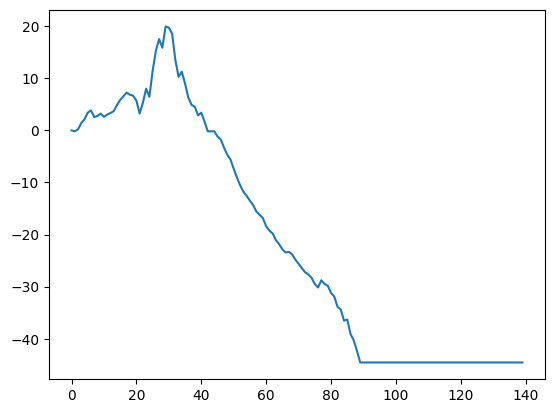

In [23]:
plt.plot(motion_data_1["camera"][:, 2])

In [24]:
def update_mesh():
    global mesh_list, params_list, simulator_t, running
    for i in range(0, len(mesh_list)):
        beta = params_list[i]["beta_interp"](simulator_t)
        pose = params_list[i]["pose_interp"](simulator_t)
        position = params_list[i]["position_interp"](simulator_t)
        smpl.set_params(beta=beta, pose=pose, trans=position)
        translated_verts = smpl.verts
        # translated_verts[:, 1] -= np.expand_dims(params_list[i]["3Djoint_position_interp"](simulator_t), axis=0)[:, 8, 1]
        translated_verts[:, 1] += np.expand_dims(params_list[i]["camera_interp"](simulator_t), axis=0)[:, 2]
        mesh_list[i].update_vertex_positions(translated_verts)
        skeleton_list[i].update_node_positions(smpl.posed_J)
# SM1.update_vertex_positions(V1)
def guii():
    global simulator_t, simulator_to_end_t, running, prev_t, fps
    # psim.TextUnformatted("Some sample text")
    time_changed, simulator_t = psim.SliderFloat("time", simulator_t, v_min=0, v_max=simulator_to_end_t)
    if psim.IsKeyPressed(psim.GetKeyIndex(psim.ImGuiKey_Space)):
        running = not running
    if running:
        dt = time.time() - prev_t
        simulator_t += dt * fps
        if simulator_t > simulator_to_end_t:
            simulator_t = 0
        update_mesh()
    else:
        if time_changed:
            update_mesh()
    prev_t = time.time()
params_list = [motion_data_1]
mesh_list = []
skeleton_list = []
skeleton_curve_edges = []
for i in smpl.parent:
    skeleton_curve_edges.append([i, smpl.parent[i]])
skeleton_curve_edges = np.array(skeleton_curve_edges)

ps.set_verbosity(0)
ps.set_SSAA_factor(4)
ps.set_program_name("Interactive Viewer")
ps.set_ground_plane_mode("tile")
# ps.set_view_projection_mode("orthographic")
ps.set_autocenter_structures(False)
ps.set_autoscale_structures(False)
ps.set_front_dir("z_front")
ps.set_up_dir("neg_y_up")
ps.set_background_color([0, 0, 0])
ps.init()



# global variables for controlling simulator
simulator_t = 0
simulator_to_end_t = params_list[0]["time"][-1]
running = False
fps = 24
prev_t = time.time()
# iterate through each clip to create the mesh + load the parameters
for i in range(0, len(params_list)):
    params = params_list[i]
    smpl.set_params(beta=params["beta"][0], pose=params["pose"][0], trans=params["position"][0])
    mesh_list.append(ps.register_surface_mesh("mesh_{}".format(i), smpl.verts, smpl.faces, color=[0.9,0.9,0.9], smooth_shade=True, edge_width=0.25, transparency=0.5))
    skeleton_list.append(ps.register_curve_network("skeleton_{}".format(i), smpl.posed_J, skeleton_curve_edges, radius=0.01, color=[1, 0, 0]))
ps.set_user_callback(guii)
ps.show()